# Identification of Bona Fide DNA Sequences with Deep Learning

In [535]:
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv1D,Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

## Data Preprocessing

In [541]:
# Encoding Scheme
# A: 1
# C: 2
# G: 3
# T: 4

# Turns a sequence of DNA into a vector
# Replaces
def seq_to_vec(sequence):
    sequence = sequence.replace(" ","")
    sequence = sequence.replace("\n","")
    vec = np.zeros(len(sequence))
    for i,s in enumerate(sequence):
        c = 0
        if s == "A":
            c = 1
        elif s == "C":
            c = 2
        elif s == "G":
            c = 3
        elif s == "T":
            c = 4
        
        # N means unknown, randomly choose
        # Note: this happens very little
        if c == 0:
            c = np.random.choice([1,2,3,4])
        
        vec[i] = c
            
    return vec

# Turns a vector of numbers back into the DNA sequence
def vec_to_seq(vec):
    seq = ""
    for i in vec:
        if i == 1:
            seq += "A"
        if i == 2:
            seq += "C"
        if i == 3:
            seq += "G"
        if i == 4:
            seq += "T"
    return seq
        

In [542]:
# Read Real Sequences
big_seq = ""
seq_file = open("bigseq.txt","rb")
for line in seq_file:
    big_seq += line    

In [543]:
# Get real sequences
big_seq = big_seq.replace(" ","") # filter white space
big_seq = big_seq.replace("\n","")
real_seqs = np.zeros((num_seqs, seq_length))
for i in range(num_seqs):
    seq = big_seq[i*seq_length: (i+1)*seq_length]
    vec = seq_to_vec(seq)
    real_seqs[i] = vec

In [544]:
# Generate Fake Sequences
seq_length = 10000
num_seqs = 3500
fake_seqs = np.random.randint(4,size=(num_seqs,seq_length))+1

In [545]:
# Assign data to X and labels to y
X = np.zeros((2*num_seqs, seq_length))
y = np.zeros(2*num_seqs)

X[:num_seqs] = fake_seqs
y[:num_seqs] = 0

X[num_seqs:] = real_seqs
y[num_seqs:] = 1

max_length = seq_length

## Data Exploration

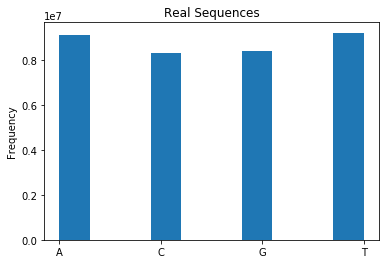

In [546]:
plt.hist(real_seqs.flatten());
plt.title("Real Sequences");
plt.ylabel("Frequency");
plt.xticks(np.arange(1,5), ('A', 'C', 'G', 'T'));
plt.savefig("Real.png",dpi=500)

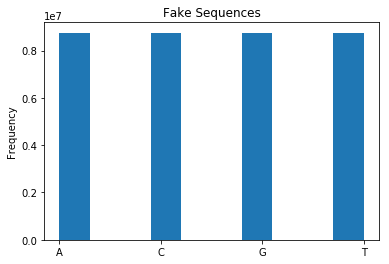

In [547]:
plt.hist(fake_seqs.flatten());
plt.title("Fake Sequences");
plt.ylabel("Frequency");
plt.xticks(np.arange(1,5), ('A', 'C', 'G', 'T'));
plt.savefig("Fake.png",dpi=500)

In [548]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y)

## CNN Model

In [549]:
X_train_exp = np.expand_dims(X_train, axis=2) # add extra dimesion to make keras happy

In [550]:
model = Sequential()
model.add(Conv1D(16, 2, activation='relu', input_shape=(seq_length,1)))
model.add(Conv1D(16, 2, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(16, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train_exp, y_train, batch_size=16, epochs=10, validation_split=0.2)

Train on 4200 samples, validate on 1050 samples
Epoch 1/10
4200/4200 [==============================] - 28s - loss: 0.6911 - acc: 0.5364 - val_loss: 0.6815 - val_acc: 0.5295
Epoch 2/10
4200/4200 [==============================] - 24s - loss: 0.6640 - acc: 0.6198 - val_loss: 0.5704 - val_acc: 0.8848
Epoch 3/10
4200/4200 [==============================] - 24s - loss: 0.5005 - acc: 0.7883 - val_loss: 0.4360 - val_acc: 0.8019
Epoch 4/10
4200/4200 [==============================] - 24s - loss: 0.3314 - acc: 0.8829 - val_loss: 0.2421 - val_acc: 0.9505
Epoch 5/10
4200/4200 [==============================] - 24s - loss: 0.2811 - acc: 0.9021 - val_loss: 0.2060 - val_acc: 0.9533
Epoch 6/10
4200/4200 [==============================] - 24s - loss: 0.2446 - acc: 0.9212 - val_loss: 0.1843 - val_acc: 0.9552
Epoch 7/10
4200/4200 [==============================] - 24s - loss: 0.2109 - acc: 0.9369 - val_loss: 0.2468 - val_acc: 0.9286
Epoch 8/10
4200/4200 [==============================] - 24s - loss: 0.

In [522]:
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_129 (Conv1D)          (None, 9999, 16)          48        
_________________________________________________________________
conv1d_130 (Conv1D)          (None, 9998, 16)          528       
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 3332, 16)          0         
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 3330, 16)          784       
_________________________________________________________________
global_average_pooling1d_26  (None, 16)                0         
_________________________________________________________________
dense_164 (Dense)            (None, 100)               1700      
_________________________________________________________________
dropout_94 (Dropout)         (None, 100)               0         
__________

## Model Performance

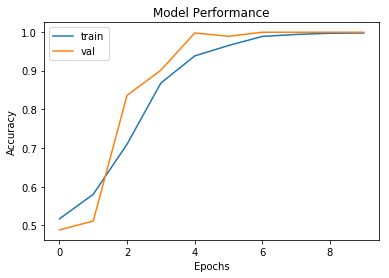

In [498]:
plt.plot(history.history["acc"],label="train")
plt.plot(history.history["val_acc"],label="val")
plt.legend()
plt.title("Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("cnn_loss.png",dpi=500)

# Test Accuracy

In [552]:
X_test_exp = np.expand_dims(X_test, axis=2)

In [553]:
scores = model.evaluate(X_test_exp, y_test, verbose=0)
print scores

[0.11449907280717578, 0.96857142857142853]


In [554]:
y_pred = model.predict_proba(X_test_exp)

1728/1750 [============================>.] - ETA: 0s

In [555]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [537]:
y_pred

array([[ 0.01212091],
       [ 0.99886858],
       [ 0.00739777],
       ..., 
       [ 0.05142074],
       [ 0.00933153],
       [ 0.99968159]], dtype=float32)

In [538]:
y_test

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

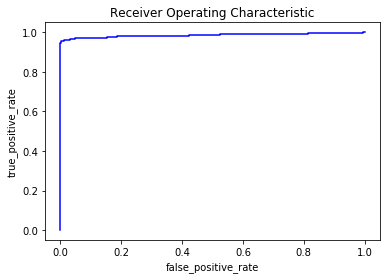

In [557]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.xlabel("false_positive_rate")
plt.ylabel("true_positive_rate")
plt.savefig("ROC.png",dpi=500)

In [518]:
# Scratch Work

In [519]:
# # create the model
# embedding_vecor_length = 32
# model = Sequential()
# model.add(Embedding(top_words, embedding_vecor_length, input_length=max_length))
# #model.add(Dropout(0.5))
# model.add(LSTM(100))
# #model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())
# model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)
# # Final evaluation of the model
# #scores = model.evaluate(X_test[:100], y_test[:100], verbose=0)
# #print("Accuracy: %.2f%%" % (scores[1]*100))

In [520]:
# scores = model.evaluate(X_test, y_test)
# print scores
# print("Accuracy: %.2f%%" % (scores[1]*100))